# Table of Contents
1. [Description](#description)
2. [Workflow](#Workflow)
   1. [Importance strategies working directly from the data](#data)
       1. [Spearman's rank correlation coefficient](#ssrc)
       2. [Linear coef featimp](#lcf)
       2. [PCA](#pca)
       3. [mRMR](#mrmr)
    2. [Model-based importance strategies](#model)
        1. [Drop column importance](#drp) 
        2. [Permutation importance](#per)
7. [Comparing strategies](#com)
8. [Automatic feature selection algorithm](#auto)
9. [Variance and empirical p-values for feature importances](#var)
10. [Wine quality Data(classification)](#class)
---

<a name="description"></a>
# Description
For this project, I implemented the various feature importance algorithms and explored how to select features in a model. I used two data sets to showcase both regression and classification scenarios of those algorithms. Further, I compared those algorithms side by side and developed an automatic feature selection algorithm. Finally, in order to support visual evdience of feature importances, I used booststrapped strategy and derivate statistical results of variance, standard deviation as well as p-values of importance of features.

We know variance and covariance are essential of data science, to put it simply, those one-to-many sometimes many-to-many relationships between results and causations are the lucrative information we are chasing after all. Being able to precisely quantify the importance of those ‘causations’ can help us to refocus scarce resources, to save or relocate and use time and money in a more efficient way. 

In the world of data science, we refer to those measurements as ‘feature importance’ (`FI`). People have invented various ways to quantify feature importance, each method has its own drawbacks and benefits. We will explore some of the most popular ones in the following. 

---

<a name="Workflow"></a>
# Workflow
For developing and demonstration purposes, I will use the `Boston housing` dataset first. Here ‘Y’ will be the house pricing and ‘X’ are the rest of the features.

In order to have a baseline for ‘sanity check’, I added a Gaussian noise column. Theoretically, if we got any feature’s importance below the noise column’s importance, those features are not convincing enough to be considered important, we should be able to drop them just as we can drop the ‘noise’ column without risk of losing too much (if any) predicting power. 

Further, some of the algorithms such as PCA, requires data in different dimension have the same scale, thus I used sklearn’s `StandardScaler` to transform X first and then feed it into all algorithms so that we can do a fair comparison among the performances.


In [346]:
import warnings
warnings.filterwarnings("ignore")
%run featimp

In [194]:
# use boston data
X, y = shap.datasets.boston()
# trying add a noise column
noise = pd.Series(np.random.normal(0,1,X.shape[0]),name='noise')
X_noise = X.join(noise)
# scale X
scale_X = StandardScaler().fit_transform(X_noise)
scale_X = pd.DataFrame(scale_X,columns=list(X_noise))
scale_X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,noise
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0.846455
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.619736
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,0.501075
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,-1.022758
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,0.884283


## Column description

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per $10,000
* PTRATIO - pupil-teacher ratio by town

* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in $1000's
* <font color = 'red'> noise</font> - artificial gaussian noise columns to serve as a beseline 

<a name="data"></a>
## Importance strategies working directly from the data

<a name="ssrc"></a>
### Spearman's rank correlation coefficient
The simplest technique to identify important regression features is to rank them by their Spearman's rank correlation coefficient; the feature with the largest coefficient is taken to be the most important. This method is measuring single-feature relevance importance and works well for independent features, but suffers in the presence of codependent features. Groups of features with similar relationships to the response variable receive the same or similar ranks, even though just one should be considered important.

In [4]:
# mg_df = scale_X.merge(pd.DataFrame(y,columns=['y']),left_index=True, right_index=True)
# sorted_featimp = mg_df.corr(method='spearman')['y'][:-1].sort_values(ascending=False)

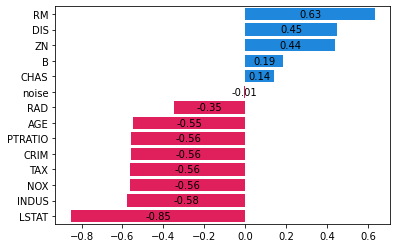

In [2]:
spearman_result = Spearman_featimp(scale_X,y)
visualizing(spearman_result)

> As we can see from the above-sorted feature importance and their corresponding plot, `RM` has the most positive influence and `LSTAT` has the most negative influence on house price, as for the random noise column I added, it has the least amount of FI and it is negligible. This is what we are expecting to see.

However, it seems like there are groups of features receive the same or similar ranks. Taking drawback of  Spearman's rank correlation coefficient into consideration, those features might be correlated.  

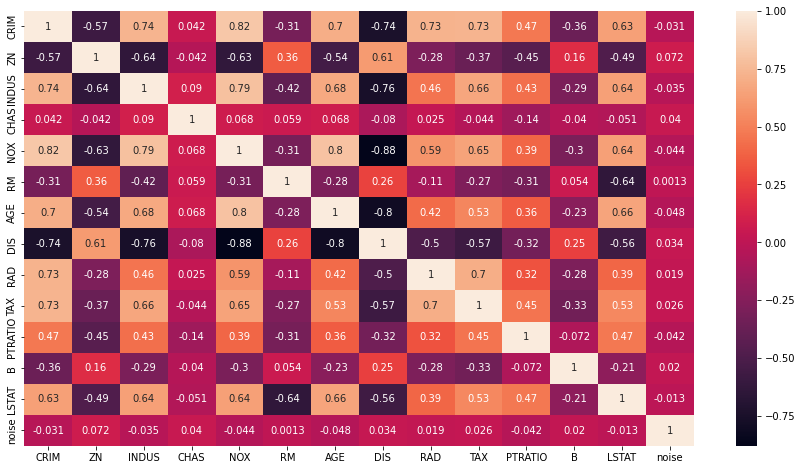

In [3]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
sns.heatmap(scale_X.corr('spearman'),annot=True);

> As we can see, there is a number of features that are highly correlated to each other, for example, `CRIM`, `NOX`, `TAX`, `INDUS`, this explains why they received similar importance scores and motivated me to find another approach that can overcome this.


<a name="lcf"></a>
### Linear coef featimp

Another similar approach to Spearman's rank correlation is to use a standard correlation coefficient, a.k.a Pearson's correlation coefficient. 

The fundamental difference between the two correlation coefficients is that the Pearson coefficient works with a linear relationship between the two variables whereas the Spearman Coefficient works with monotonic relationships as well.

However,  Pearson's correlation coefficient is very limited to a linear relationship between two variables. Thus, if the relationships are not exactly linear and we use Pearson's coefficient then we’ll miss out on the information that Spearman could capture. As we can see below.


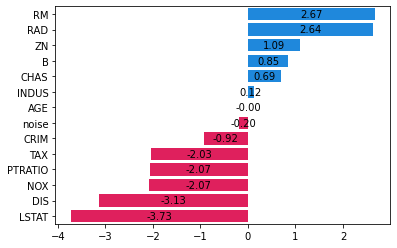

In [4]:
linear_result = linear_featimp(scale_X,y)
visualizing(linear_result)

> Some of the features received dramatically different FI scores (change signs) compare to Spearman's rank correlation approach. This indicates some unrobustnesses if we use coefficient as an indicator of feature importance.

<a name="pca"></a>
### PCA

* Note: 

>Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. This step was performed during data preprocessing.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

* To investigate the features, I mapped each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Using the data columns description can help us understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.

Let's first check out some `PC`'s (principle component).

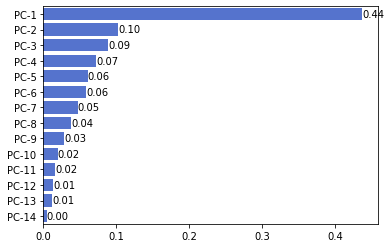

In [5]:
pca = PCA(n_components=None)#.fit(scale_X)
pca.fit(scale_X)
# check how much each variance each pc exlpain
ratios =pca.explained_variance_ratio_
# 1st pc explains 44% of total ratios
fig, ax = plt.subplots()
sns.barplot(x = ratios,y = [f'PC-{i+1}' for i in range(len(ratios))],color='royalblue',ax=ax)
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge');

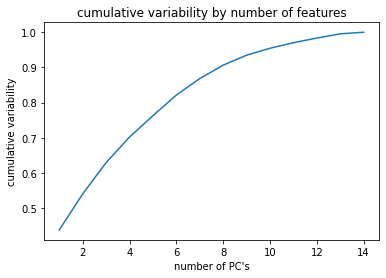

In [6]:
# cumulative variability
cumulative=[]
result=0
for i in ratios:
    result+=i
    cumulative.append(result)
    
sns.lineplot(x = np.arange(len(ratios))+1,y = cumulative)
plt.title('cumulative variability by number of features')
plt.xlabel("number of PC's")
plt.ylabel('cumulative variability');

> Since `PC-1` explains around 44% of total variance ratios against target y already, we can safely turn to the `PC-1` dimension and take a look at what are the features that contribute the most in both positive and negative ways.

What happens if we don't normalize the data to the same scale before we do PCA? Let's compare them side by side:

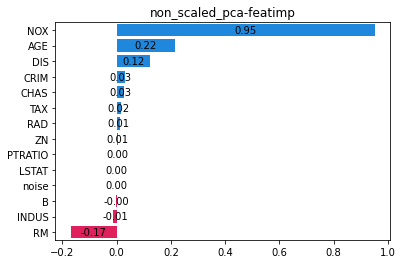

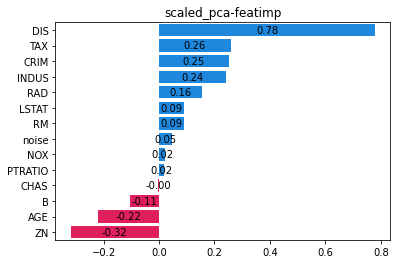

In [10]:
non_scale_pca = pca_featimp(X_noise,scale_X=False)
pca_result = pca_featimp(scale_X,scale_X=False)

pca_compare = pd.concat([non_scale_pca,pca_result],axis=1)
pca_compare.columns = ['non_scaled_pca','scaled_pca']

visualizing(non_scale_pca)
plt.title('non_scaled_pca-featimp')
plt.show()

visualizing(pca_result)
plt.title('scaled_pca-featimp');

> There is a remarkable difference between scaled and non-scaled X. Without normalization, small-scaled features won’t big impact on target variable y, this is obviously unfair if we want to compare feature importance. Once we standard scale it, the result makes much more sense.

PCA projects data into a new space characterized by eigenvectors and identifies features that explain the most variance in the new space. Features show their relative importance only in the corresponding PC dimension. Due to this fact,  each feature’s importance in different PC dimensions might be different and unexpected.

<a name="mrmr"></a>
### mRMR (Spearman's rank coefficient for function I)

In an effort to deal with codependencies, data analysis techniques rank features not just by relevance (correlation with the response variable) but also by low redundancy, the amount of information shared between codependent features, which is the idea behind minimal-redundancy-maximal-relevance (mRMR):

<img src="mRMR.png" width="300">

mRMR generally works very well, although it does not account for interactions and non-pairwise redundancy, it has a good compromise between relevance and redundancy.

The `I` function that measures the association between variables can be many things, here I used Spearman's rank coefficient. Then I sumed Spearman's rank coefficient between each feature and other feaures, during which I needed to -1 in order to correct each feature's correlation with itself is 1. Finally devided it by the total number of features (|S| is the length of selected features)

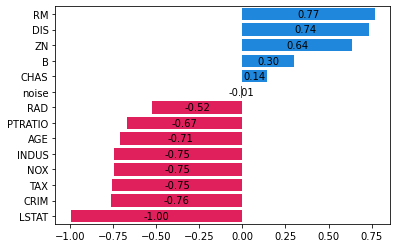

In [11]:
mrmr_result = mRMR_featimp(scale_X,y)
visualizing(mrmr_result)

So far we have seen four different feature importance strategies working directly from the data. Their results are not consistent but their importance ranks are reasonable in most cases. There are disadvantages in each of them. Now we are switching to some model-based importance strategies and see if they will do better.
<a name="model"></a>
## Model-based importance strategies
<a name="drp"></a>
### Drop column importance

The idea is quite simple and straightforward: 
1. First, we compute the validation metrics for the model trained on all features. This is our baseline.
2. Drop column $x_{j}$ from the training set, one at a time
3. Retrain model
4. Compute validation metric set (OOB score in this case)
5. Importance score is the change in metric

This answers the question of how loss of a feature affects overall 
model performance (which might not be actual importance)

In [12]:
# init RF regressor
rf = RandomForestRegressor(oob_score=True)

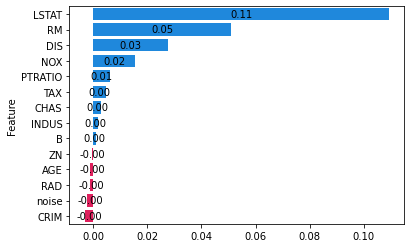

In [14]:
drop_result = dropcol_importances(rf,scale_X,y,random_state=True)
visualizing(drop_result)

> About random state: 

" we are specifically looking at changes to the performance of a model after removing a feature. By controlling the random state, we are controlling a source of variability. Any change in performance should be due specifically to the drop of a feature. "

This bar plot makes so much sense in terms of OOB score. Any feature that shows a negative value in the plot means dropping it will actually increase the OOB score! We can safely drop them off then. This approach works great for any machine learning model and it is very intuitive, but the downside is it is an expensive method because it retrains the model n times for n features. Codependent features often result in 0 or very low importance because if we drop one of them, another codependent feature can still cover for the loss thus the OOB score won’t change that much and reflects not as important. This misleading information could misguide us to drop important features.

<a name="per"></a>
### Permutation importance

To work around this codependent problem, we can break the potential connection between features by shuffling the record in each feature. Further, this method is much more efficient than drop column importance since we don’t need to retrain the model for each permutation, we just have to re-run the perturbed test samples through the already-trained model.

Procedure:
1. Compute validation metric for a model trained on all features
2. Permute column $x_{i}$ in the validation set
3. Compute validation metric set
4. Importance score is the change in metric

* Note: metric used {regression: $R^2$, classification: accuracy}

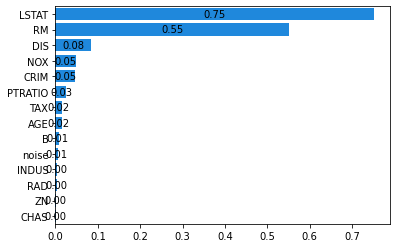

In [15]:
permu_result = permutation_importances(rf,scale_X,y)
visualizing(permu_result)

> One thing worth stressing is that the permutation approach can't distinguish between a positive and negative change in feature importance. Anytime we change shuffle one column it almost always decreases the $R^2$ score (take regression as an example). This is because we broke the codependence between the shuffled column and other columns but at the same time, we broke the correct covariance to target y. This is one of the disadvantages of this method: it can create nonsensical records through permutation,
such as pregnant males, which makes the results suspect. We can only measure the change in magnitude of the metric we are using, the bigger the change, the bigger the negative impact of shuffling this column has on predicting y. In another word, the more important this feature is. Often, codependent features share importance, such as `CRIM` and `NOX`. Any column has a `FI` less than the `noise` column we can drop it.

---
<a name="com"></a>
# Comparing strategies

Now we have all feature importances from different approaches, let’s compare their performances in terms of predicting power on the same scale. The idea is simple:

Procedure:
1. Collect all 6 algorithms’ feature importances, rank the `FI` by absolute value correspondingly.
2. Start from the least important feature, drop one feature at a time across all six algorithms’ FI rank
    1. Feed the rest of the features across all six algorithms to the same predicting model. I used OLS, RF, and XGBoost models for comparison. On top of that, I utilized the 5-fold cross-validation method to minimize the effect of any randomness. This way, we are setting six different `FI` ranks on the same starting point.
    2. Predict target y and record the CV loss (here I used MAE)
3. Simply compare the CV loss across all six algorithms when they have the amount of ‘top k most importance features’ accordingly.


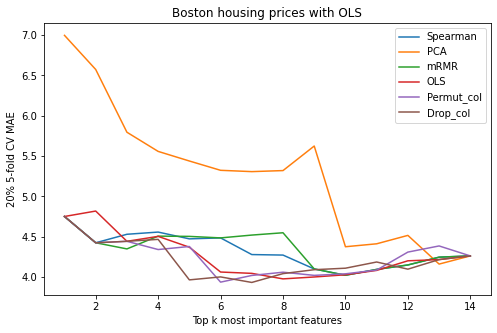

In [36]:
ols_df = compare_strategies('OLS',scale_X,y)

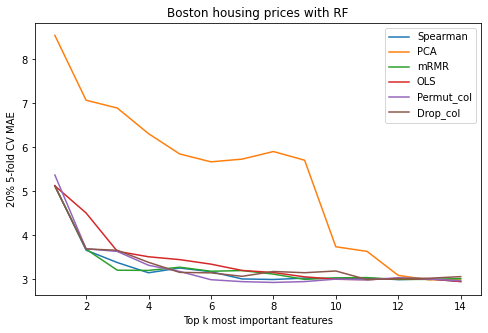

In [37]:
rf_sf = compare_strategies('RF',scale_X,y)

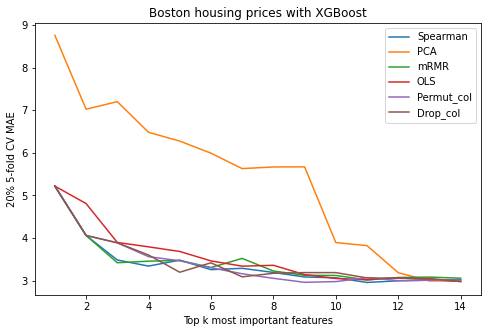

In [38]:
xg_df = compare_strategies('XGBoost',scale_X,y)

> According to the three predicting models I tried, PCA underperformed all other algorithms in terms of the number of top k most important features needed. On the other hand, the ‘Permutation’ approach shows a really promising result: predicting models only need six to nine top features picked out by permutation importance can shrink MAE to the same amount or even smaller than other algorithms with all features.

## Compare permutation importance to shap feature importance

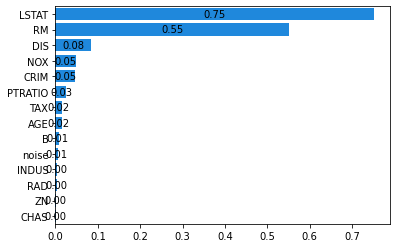

In [ ]:
# permutation importance
visualizing(permu_result)

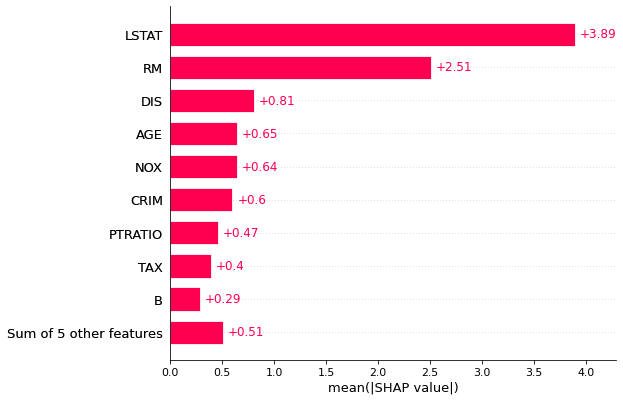

In [43]:
# shap mean absolute value of feature importance
model = xgboost.XGBRegressor().fit(scale_X,y)
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(scale_X,y)

# mean absolute value of the SHAP values
shap.plots.bar(shap_values)

For a quick sanity check, I used [SHAP](https://github.com/slundberg/shap) mean absolute value of feature importance to compare with permutation feature importance result. The top three most important features are the same but the order of the next six features that above `noise` column is different. This is reasonable since different models use a different metric to ‘define’ importance. All the columns that were rated below the `noise` column are also marked not important by SHAP, which means our permutation algorithm did a very satisfying job! 

To this point, I will use `Permutation importance` for following analysis.

---
<a name="auto"></a>
# Automatic feature selection algorithm

Now, all we need is a mechanism to drop off unimportant features and keep the top k, for some k we don't know beforehand. Recall permutation only measures the magnitude of metric change, since I added a Gaussian noise column, any column’s feature importance below the noise column we can just simply drop it. Of course, we will drop the noise column as well.

Procedure:
1. Compute metrics (I used MSE for regression and log loss for classification problem) with all features including the `noise` column, this serves as a pseudo-baseline
2. Use the permutation feature method to compute importance and keep only the columns that are ranked higher than the `noise` column. This is the real baseline.
3. Dropped the lowest importance feature and retrain the model and re-computing the validation metric. 
    > NOTE: Because of co-dependencies between features, we must recompute the feature importances after dropping each feature.

    > NOTE: Instead of keeping the baseline static, we must keep updating the baseline for every interaction and compare the current metric to the former metric. This way, we know If the validation metric is worse, then we have dropped one too many features. 
4. Stop the iteration once the current metric is worse than the previous one and return the features selected by the former step.


In [253]:
rf = RandomForestRegressor(oob_score=True)
features, xs,ys =auto_feat_select(X,y,rf)

In [255]:
print(f"Selected important features are {features}")

Selected important features are ['RM', 'LSTAT', 'DIS', 'NOX', 'CRIM', 'PTRATIO', 'TAX', 'AGE']


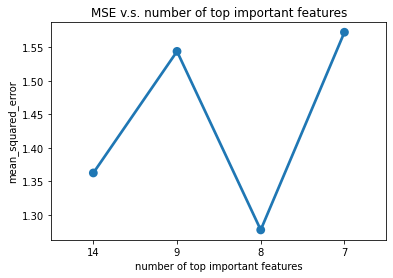

In [256]:
sns.pointplot(x = [str(x) for x in xs],y = ys)
plt.xlabel('number of top important features')
plt.ylabel('mean_squared_error')
plt.title('MSE v.s. number of top important features');

> Note: the second point spiked because we drop all the feature has lower importance than a noise column, this lead to a little bit deteriorate in terms of our mertic but made sure there was not feature kept due to randomness.

For this experiment, there are eight features were selected to keep. We stopped at eight because when the algorithm dropped the number of features to seven, there is a clear spike in MSE loss.

---
<a name="var"></a>
# Variance and empirical p-values for feature importances

Now that we have a good selection of important features, the only thing we need to make sure of is those `FI` are statistically significant. This requires bootstrapping pair with hypothesis testing and it means that we can compute variance or standard deviation of the feature importances. It is a very powerful tool giving a very limited amount of data we can make ‘educated guesses’ of whether or not a feature is  ‘truly important.

In [343]:
# take out the important features marked by permutation importance 
# (above noise column)
x_imp = StandardScaler().fit_transform(X[features])
x_imp = pd.DataFrame(x_imp,columns=list(X[features]))

100%|████████████████████████████████| 1000/1000 [04:28<00:00,  3.73it/s]


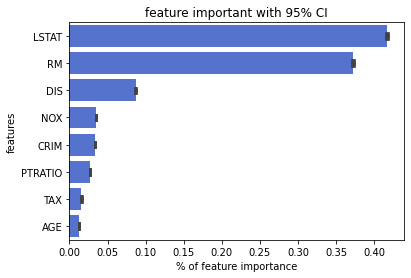

In [344]:
emp_df = empirical_imp(x_imp,y,n_run=1000)
sns.barplot(data=emp_df,orient='h',color='royalblue',capsize=.2)
plt.xlabel('% of feature importance')
plt.ylabel('features')
plt.title('feature important with 95% CI');

> Here I bootstrapped 100 times and collected permutation feature importance in these 100 runs. Barplot shows the error bars with respect to a 95% confidence interval (two standard deviations). But since I ran 1000 bootstrap, the error bars were squashed into very condensed intervals.

In order to perform a hypothesis test, we need a null distribution for comparison purposes. 
Procedure:
1. Shuffling the target variable y, 
2. Compute the feature importances again
3. Repeat this process many times to simulate the bootstrap method. This distribution is that particular feature’s importance under the null hypothesis. Here we can just use the normalized permutation score each time.
4. Finally, check and see if our permute feature importance falls 95% percent threshold. (using an $\alpha$ = 2.5%*2 two tails test)


$$H_{0}: a = b$$
$$H_{a}: a != b$$
Where:

* a = calculated permutation importance
* b = random feature importance

In [335]:
null_df = empirical_imp(x_imp,y, shuffle_y=True,n_run=1000)

100%|████████████████████████████████| 1000/1000 [04:55<00:00,  3.39it/s]


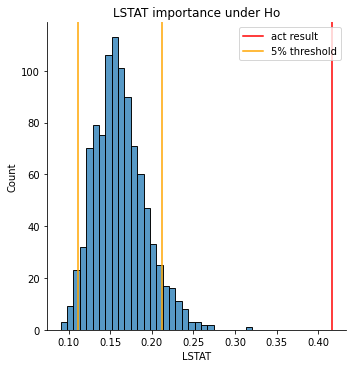

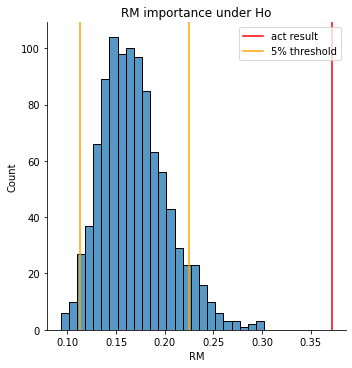

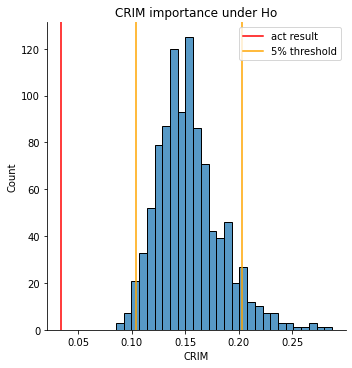

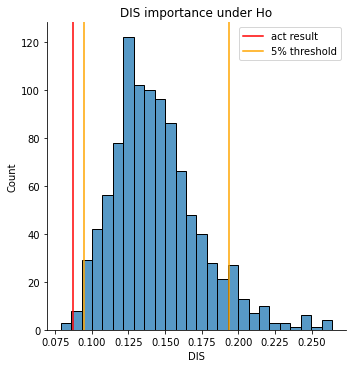

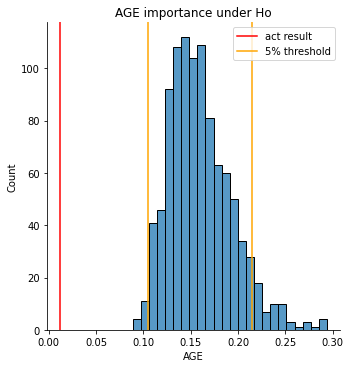

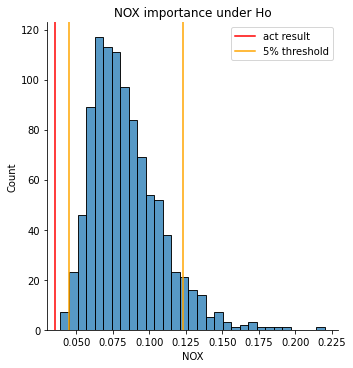

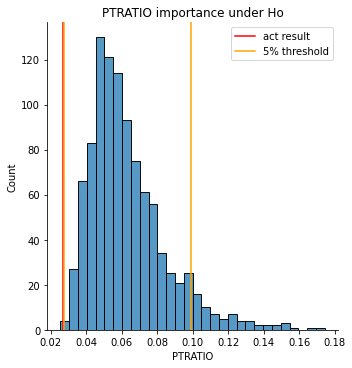

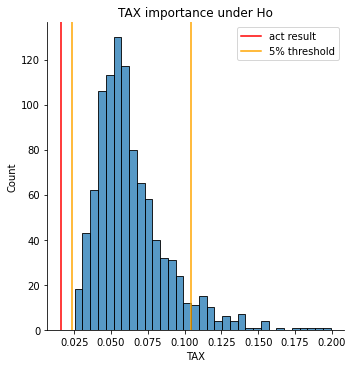

In [365]:
plot_all_features(null_df,emp_df)

> As we can see, all eight features’ importance picked out by permutation algorithm show a statistical significant, which suggests again, permutation importance method reflects a very decent true feature importance.

---
<a name="class"></a>
# Wine quality Data (Classification)
Lastly, let's test on a classification problem.

In [378]:
wine_df = pd.read_csv('winequality-white.csv',sep=';')
wine_df['quality'] = wine_df['quality'].apply(lambda x: 1 if x>5 else 0)

In [381]:
x, y = wine_df.iloc[:,:-1],wine_df['quality']

In [387]:
x.shape

(4898, 11)

## check featimp

In [396]:
noise = pd.Series(np.random.normal(0, 1, x.shape[0]), name='noise')
X_noise = x.join(noise)
X_noise_scal = pd.DataFrame(StandardScaler().fit_transform(X_noise),columns=list(X_noise))

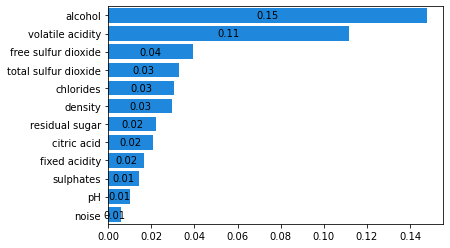

In [398]:
rf = RandomForestClassifier(oob_score=True)
permu_result = permutation_importances(rf,X_noise_scal,y)
visualizing(permu_result)

## Automatic feature selection

In [401]:
features, xs,ys = auto_feat_select(x,y, rf)
print(f"Selected important features are {features}")

Selected important features are ['alcohol', 'volatile acidity', 'free sulfur dioxide', 'density', 'chlorides', 'total sulfur dioxide', 'residual sugar', 'citric acid', 'fixed acidity']


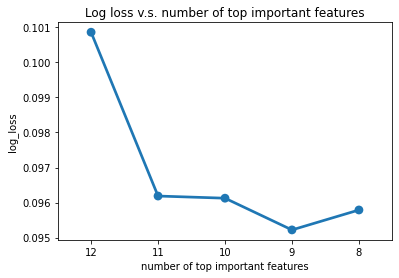

In [402]:
sns.pointplot(x = [str(i) for i in xs],y = ys)
plt.xlabel('number of top important features')
plt.ylabel('log_loss')
plt.title('Log loss v.s. number of top important features');

## empirical p-values for feature importances

In [403]:
# take out the important features marked by permutation importance 
# (above noise column)
x_imp = StandardScaler().fit_transform(x[features])
x_imp = pd.DataFrame(x_imp,columns=list(x[features]))

100%|██████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


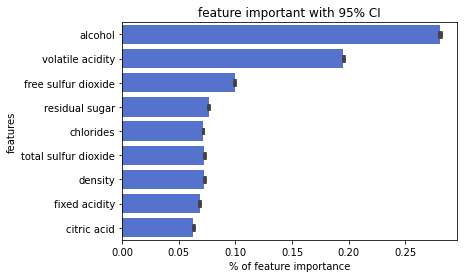

In [405]:
emp_df = empirical_imp(x_imp,y,n_run=100)
sns.barplot(data=emp_df,orient='h',color='royalblue',capsize=.2)
plt.xlabel('% of feature importance')
plt.ylabel('features')
plt.title('feature important with 95% CI');

In [407]:
null_df = empirical_imp(x_imp,y, shuffle_y=True,n_run=500)

100%|██████████████████████████████████| 500/500 [18:42<00:00,  2.25s/it]


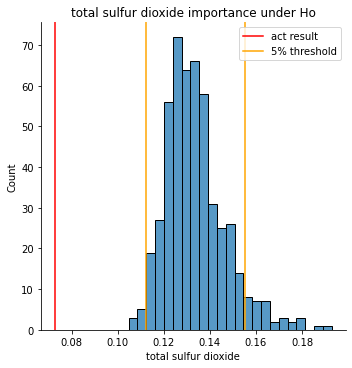

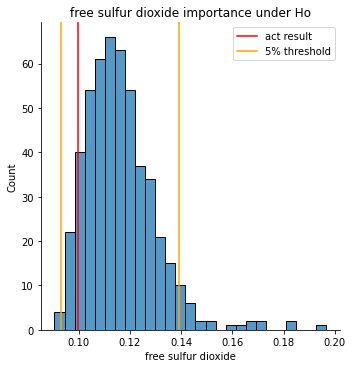

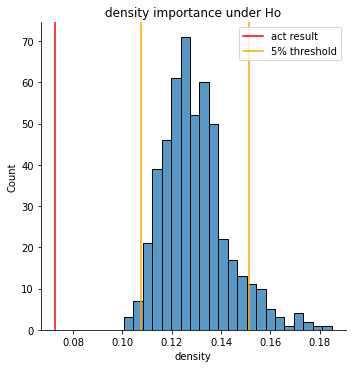

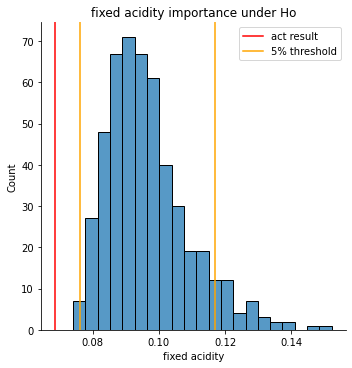

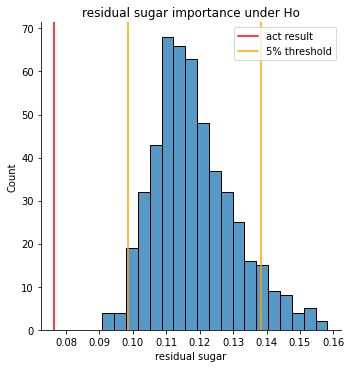

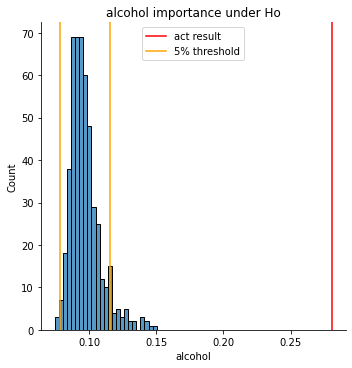

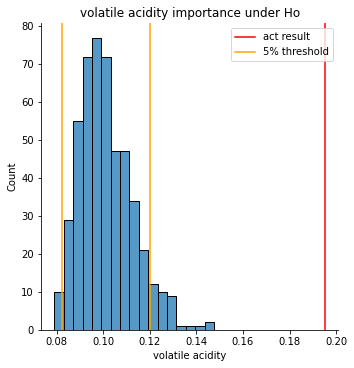

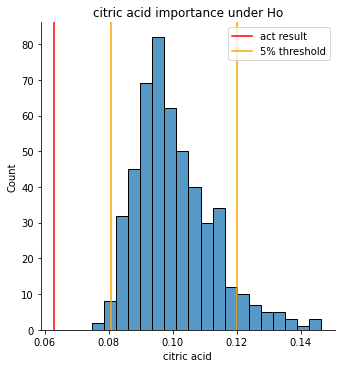

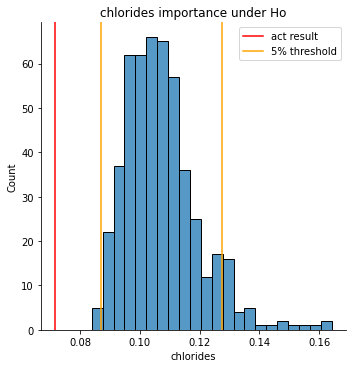

In [408]:
plot_all_features(null_df,emp_df)

* There is no free lunch. It's often the case that features determined for one model do not export well to other models.
---

<a name="ref"></a>
# References
* [Clearly explained: Pearson V/S Spearman Correlation Coefficient](https://towardsdatascience.com/clearly-explained-pearson-v-s-spearman-correlation-coefficient-ada2f473b8)
* [Information Driven Healthcare: Machine Learning course](https://www.robots.ox.ac.uk/~davidc/pubs/CDT-B1-Lecture12-MondayWeek2-FeatureSelection2.pdf)
* [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)